# Import the necessary packages

In [ ]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cryoblob as cb

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["image.cmap"] = "magma"

## Clear the font cache, and use Source Family fonts

In [ ]:
!rm -rf ~/.cache/matplotlib
from matplotlib import rcParams

rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["Source Sans 3", "Source Sans Pro"]
rcParams["font.serif"] = ["Source Serif 4", "Source Serif Pro"]
rcParams["font.monospace"] = ["Source Code Pro"]
rcParams["font.size"] = 25

# Let's load the files

## Use the file_params to get relative file paths.

In [ ]:
top_level, file_dict = cb.file_params()

### We use glob to find the list of `.mrc` files in the folder.

In [ ]:
plga_la_location = top_level + file_dict["data"]["PLGA_LA"]["Data"]
filetype = "mrc"
file_list = np.asarray(glob.glob(plga_la_location + "*." + filetype), dtype="str")

### Now let's load one dataset. We will load the data into a JAX based PyTree

In [ ]:
test_data = file_list[12]
data_mrc = cb.load_mrc(test_data)

The data_mrc is the PyTree with the following parameters:
- `image_data`: Image array (2D or 3D).
- `voxel_size`: Array containing voxel dimensions in
    Å (Z, Y, X).
- `origin`: Array indicating the origin coordinates from the
    header (Z, Y, X).
- `data_min`: Minimum pixel value.
- `data_max`: Maximum pixel value.
- `data_mean`: Mean pixel value.
- `mode`: Integer code representing data type
    (e.g., 0=int8, 1=int16, 2=float32).

There is an internal function that can directly take in the PyTree, and plot the image with the scalebar and everything.

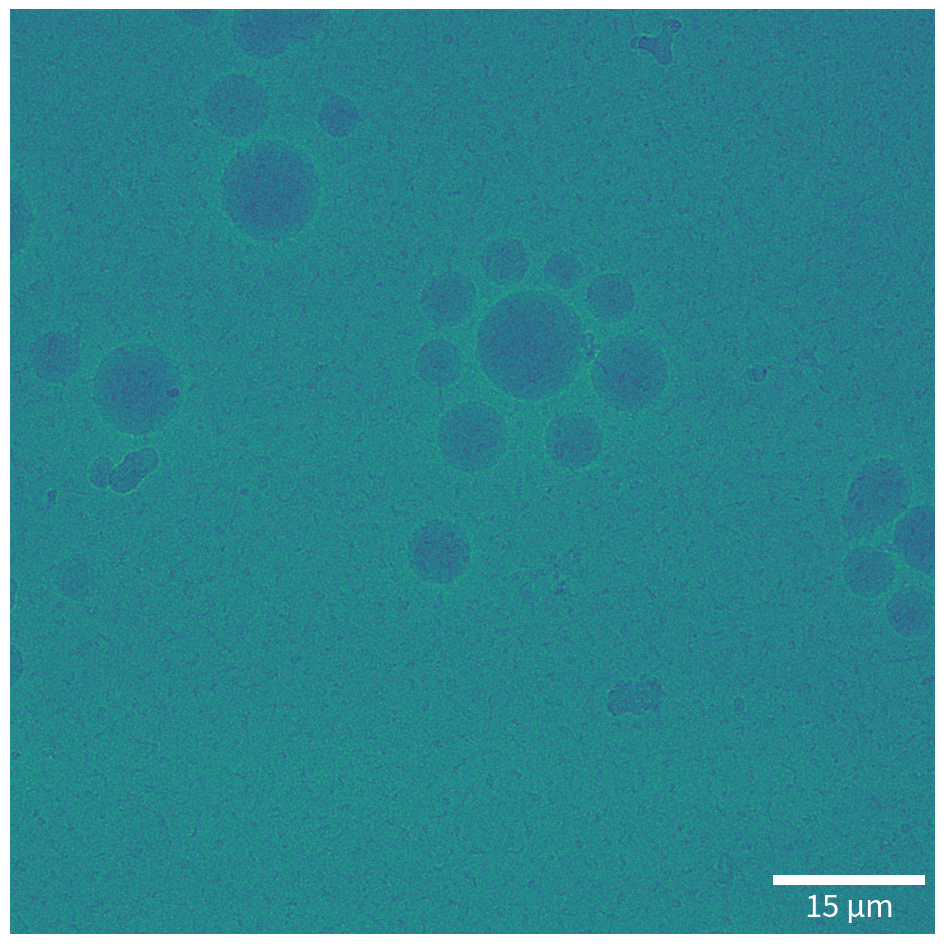

In [ ]:
cb.plot_mrc(data_mrc, (10, 10))

# Working with the data.

One thing, we need to do is to downsample the data a bit, because these datasets are $4096 \times 4096$, and convoluting them with a 96 pixel kernel is computationally needlessly expensive.

In [ ]:
ds_image = cb.image_resizer(data_mrc.image_data, 4)

#### The `cryoblob` package has the `Laplacian of Gaussian` function. Let's call it to see how fast it runs. Also, remember that the error messages that you are seeing sometimes come from XLA compiler trying to decide on the fastest convolution strategy.

In [ ]:
%timeit cb.laplacian_of_gaussian(ds_image, standard_deviation=15)

253 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Calling the function `JIT` compiles it, let's now run it on the image. We use some downsampling (`ds_factor`) to make it faster.

In [ ]:
whos

Variable           Type         Data/Info
-----------------------------------------
cb                 module       <module 'cryoblob' from '<...>rc/cryoblob/__init__.py'>
data_mrc           MRC_Image    MRC_Image(image_data=Arra<...>de=Array(6, dtype=int32))
ds_factor          int          6
ds_image           ArrayImpl    [[205.375  203.25   201.1<...>.1875 181.4375 189.8125]]
file_dict          dict         n=4
file_list          ndarray      123: 123 elems, type `<U129`, 63468 bytes
filetype           str          mrc
glob               module       <module 'glob' from '/hom<...>/lib/python3.12/glob.py'>
mrcfile            module       <module 'mrcfile' from '/<...>ges/mrcfile/__init__.py'>
np                 module       <module 'numpy' from '/kr<...>kages/numpy/__init__.py'>
pd                 module       <module 'pandas' from '/k<...>ages/pandas/__init__.py'>
plga_la_location   str          /kriosdata/Debangshu/mult<...>ata/cryo_em/PLGA_LA/Data/
plt                module       

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

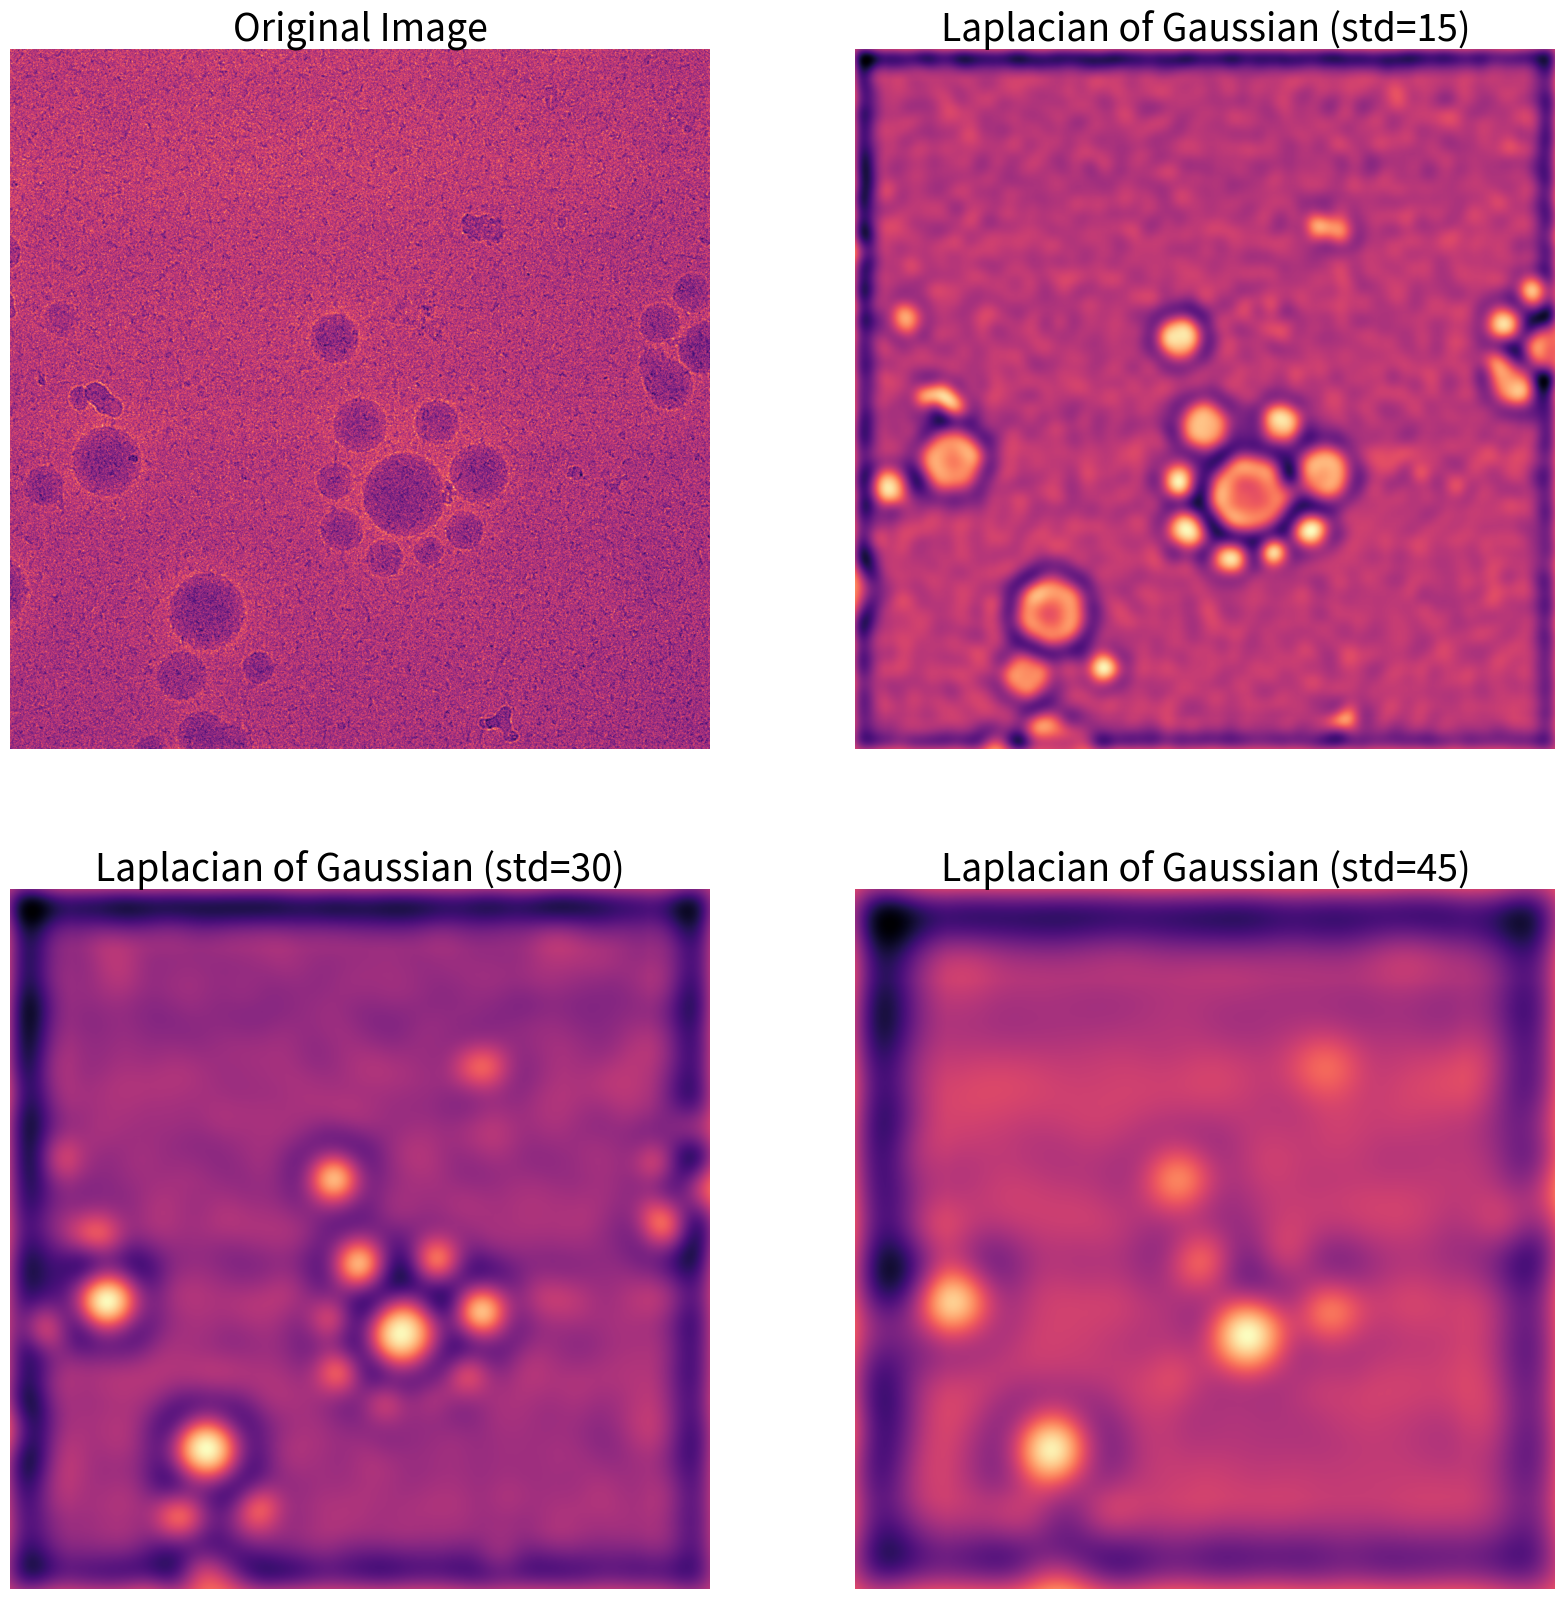

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.imshow(ds_image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
std_val = 15
plt.imshow(cb.laplacian_of_gaussian(ds_image, standard_deviation=std_val))
plt.title("Laplacian of Gaussian (std=" + str(std_val) + ")")
plt.axis("off")
plt.subplot(2, 2, 3)
std_val = 30
plt.imshow(cb.laplacian_of_gaussian(ds_image, standard_deviation=std_val))
plt.title("Laplacian of Gaussian (std=" + str(std_val) + ")")
plt.axis("off")
plt.subplot(2, 2, 4)
std_val = 45
plt.imshow(cb.laplacian_of_gaussian(ds_image, standard_deviation=std_val))
plt.title("Laplacian of Gaussian (std=" + str(std_val) + ")")
plt.axis("off")

As we can observe modifying the *standard deviation* selectively brightens the blobs, whose radius closely matches the standard deviation. This is the principle behind blob detection by the **Laplacian of Gaussians** approach - perform a series of convolutions - and then run gaussian peak fitting to locate the blob radii.

### Now, we will run the `cryoblob.blob_list` to JIT compile it, and see how it runs through a series of Standard Deviations and locates the blobs

In [ ]:
%timeit cb.blob_list(data_mrc, downscale=7)

TypeCheckError: Type-check error whilst checking the parameters of cryoblob.blobs.blob_list.
The problem arose whilst typechecking parameter 'image'.
Actual value: MRC_Image(
  image_data=u16[4096,4096](jax),
  voxel_size=f64[3](jax),
  origin=f64[3](jax),
  data_min=f32[](jax),
  data_max=f32[](jax),
  data_mean=f32[](jax),
  mode=i32[](jax)
)
Expected type: jaxtyping.Float[Array, 'a b'] | Float[Array, 'a b c'].
----------------------
Called with parameters: {
  'image':
  MRC_Image(
    image_data=u16[4096,4096](jax),
    voxel_size=f64[3](jax),
    origin=f64[3](jax),
    data_min=f32[](jax),
    data_max=f32[](jax),
    data_mean=f32[](jax),
    mode=i32[](jax)
  ),
  'min_blob_size': 10,
  'max_blob_size': 100,
  'blob_step': 2,
  'downscale': 7,
  'std_threshold': 6
}
Parameter annotations: (image: Float[Array, 'a b'] | Float[Array, 'a b c'], min_blob_size: Union[int, float, Num[Array, ''], NoneType] = 10, max_blob_size: Union[int, float, Num[Array, ''], NoneType] = 100, blob_step: Union[int, float, Num[Array, ''], NoneType] = 2, downscale: Union[int, float, Num[Array, ''], NoneType] = 2, std_threshold: Union[int, float, Num[Array, ''], NoneType] = 6) -> Any.


In [ ]:
calculated_blob_pos = arm_em.blob_list(im_data, downscale=7).get()
circle_test = np.zeros_like(im_data.get())
yy, xx = np.mgrid[0 : circle_test.shape[0], 0 : circle_test.shape[1]]
for jj in trange(len(calculated_blob_pos)):
    circle_test += (
        ((yy - calculated_blob_pos[jj, 0]) ** 2)
        + ((xx - calculated_blob_pos[jj, 1]) ** 2)
    ) < (calculated_blob_pos[jj, 2] ** 2)
del yy, xx, jj

  0%|          | 0/50 [00:00<?, ?it/s]

### Let's plot the locations and sizes of the blobs. You will notice the blob sizes are still not correct!

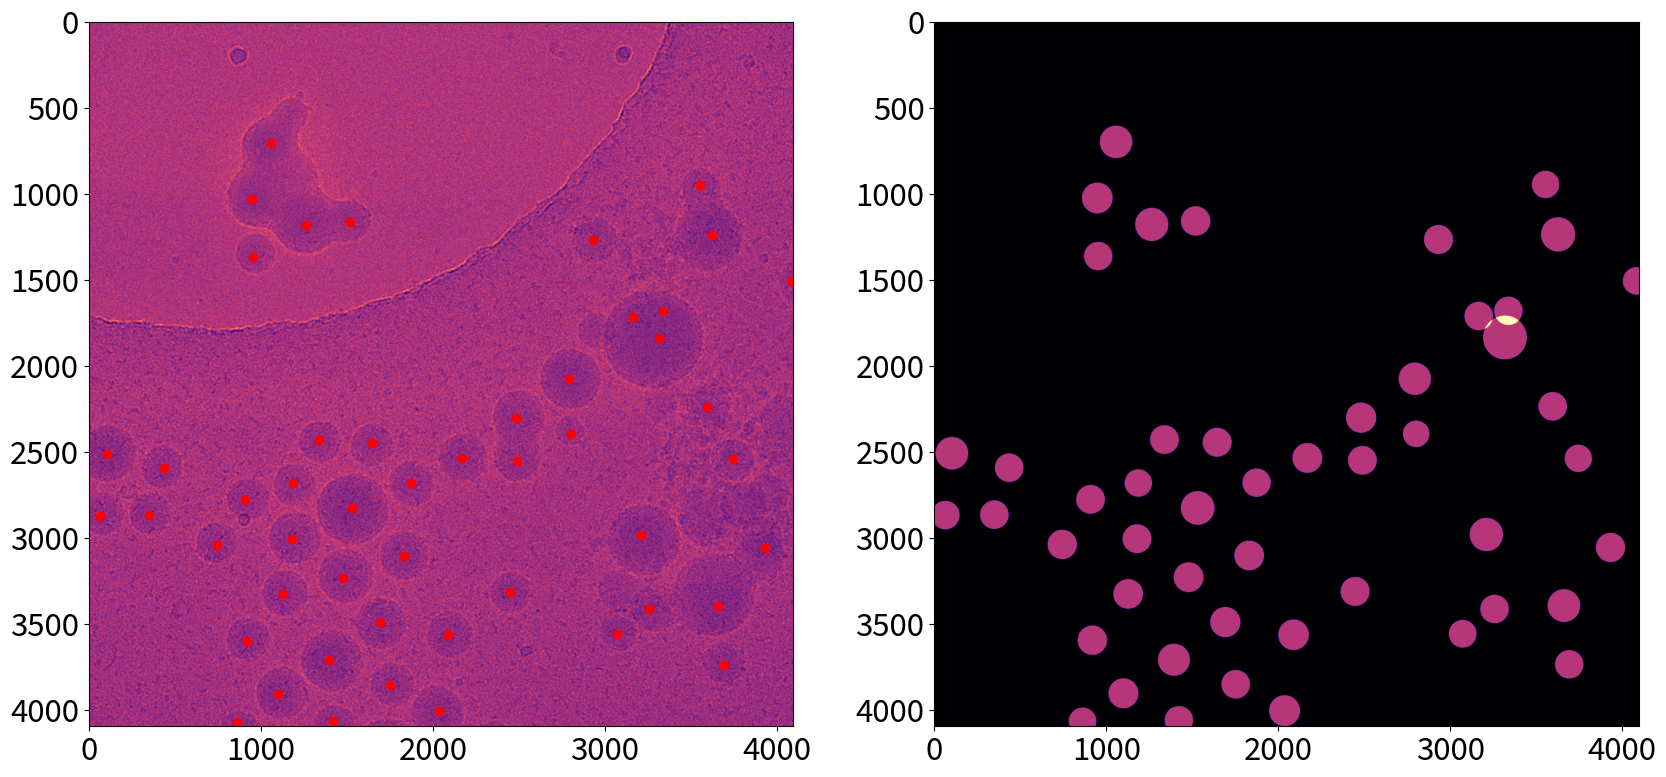

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im_data.get())
plt.scatter(calculated_blob_pos[:, 1], calculated_blob_pos[:, 0], c="r")
plt.subplot(1, 2, 2)
plt.imshow(circle_test)
plt.savefig(top_level + file_dict["results"]["PLGA_LA"] + "Figure_test.png")

### Let's save the calculated data for this single image to a CSV file

In [ ]:
calculated_blobs = pd.DataFrame(
    data=calculated_blob_pos, columns=["Center Y (nm)", "Center X (nm)", "Size (nm)"]
)
calculated_blobs.to_csv(
    path_or_buf=top_level + file_dict["results"]["PLGA_LA"] + "Blob_Test.csv"
)
calculated_blobs

Center Y (nm)  Center X (nm)   Size (nm)
0      701.824403    1057.554642   94.896959
1      949.044411    3552.870735   79.967197
2     1027.749569     948.247229   89.664230
3     1181.448958    1264.619910   96.751997
4     1161.321935    1519.739703   85.801850
5     1239.124074    3625.575260   99.734091
6     1269.087138    2930.662526   84.637600
7     1365.241792     953.384764   82.819883
8     1509.427469    4081.381593   80.197837
9     1683.266093    3336.729089   82.740077
10    1713.383712    3164.138397   82.956045
11    1838.196104    3316.845975  127.439787
12    2078.124696    2793.044504   94.245045
13    2238.222666    3594.045489   83.289754
14    2303.988105    2480.946628   88.184388
15    2431.535310    1338.661732   83.765638
16    2397.755530    2800.773241   77.337309
17    2446.987258    1644.584597   84.496807
18    2510.770600     103.690771   95.191701
19    2537.961966    2168.721004   86.974717
20    2551.979787    2488.583153   83.948937
21    2540.394629    3742.998197   79.676327
22    2594.765644     436.385246   83.201069
23    2681.723422    1873.761210   82.638576
24    2683.822368    1186.650799   79.852686
25    2828.780840    1531.728246   98.180765
26    2778.692227     909.190589   83.899493
27    2867.564817     350.141457   83.248115
28    2870.122546      65.609280   83.045672
29    2982.936401    3208.901160   97.125728
30    3007.199842    1179.018924   84.173703
31    3040.657897     744.635036   85.609994
32    3058.406309    3930.151624   85.309582
33    3104.936864    1830.761975   86.765413
34    3230.978606    1478.856645   87.030088
35    3327.903427    1127.608967   86.327970
36    3313.830515    2446.209772   84.659131
37    3396.036852    3659.300534   95.306815
38    3415.727533    3256.429493   83.046130
39    3491.710163    1692.466862   88.097892
40    3565.363766    2088.776308   89.254202
41    3596.922250     919.725711   85.652463
42    3559.458532    3071.032111   80.828867
43    3710.509604    1393.648179   93.348546
44    3737.140057    3690.105307   82.815782
45    3852.982310    1752.529609   83.466203
46    3905.507194    1100.187579   87.366941
47    4006.658796    2036.527417   90.112077
48    4062.175084    1422.264761   83.013623
49    4067.948931     862.803682   80.294837